# Loading the dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datasets import load_dataset

ds = load_dataset("ylecun/mnist")

In [4]:
df_train = pd.DataFrame(ds['train'])
df_train['label'].unique()

array([5, 0, 4, 1, 9, 2, 3, 6, 7, 8])

## Generating the required data

In [5]:
df = pd.DataFrame()
for i in range(10):
    df_i = df_train[df_train['label'] == i]
    df_i = df_i.sample(n=100, random_state=42)
    df = pd.concat([df, df_i], axis=0) 
    

In [6]:
df.reset_index(drop=True, inplace=True)

In [7]:
X = df['image'].to_numpy()
y = df['label'].to_numpy()
X.shape

(1000,)

# Visualization

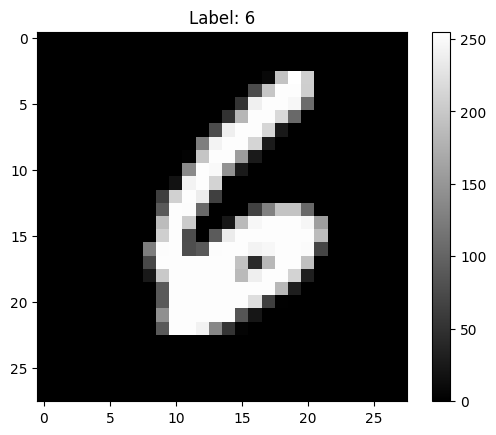

In [8]:
plt.imshow(X[675], cmap='gray')
plt.title(f'Label: {y[675]}')
plt.colorbar()
plt.show()

In [9]:
X_array = np.array([np.array(image).flatten() for image in X])
X_array = X_array/255
X_array.shape

(1000, 784)

In [10]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None
        self.explained_variance = None
        self.explained_variance_ratio = None

    def fit(self, X):
        # Step 1: Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # Step 2: Compute the covariance matrix
        covariance_matrix = np.cov(X_centered, rowvar=False)

        # Step 3: Eigendecomposition of covariance matrix
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # Step 4: Sort eigenvectors by eigenvalues in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Step 5: Select the top n_components eigenvectors and eigenvalues
        self.components = eigenvectors[:, :self.n_components]
        self.explained_variance = eigenvalues[:self.n_components]
        
        # Calculate explained variance ratio
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = self.explained_variance / total_variance
        return self.explained_variance 
    
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)

    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.components.T) + self.mean

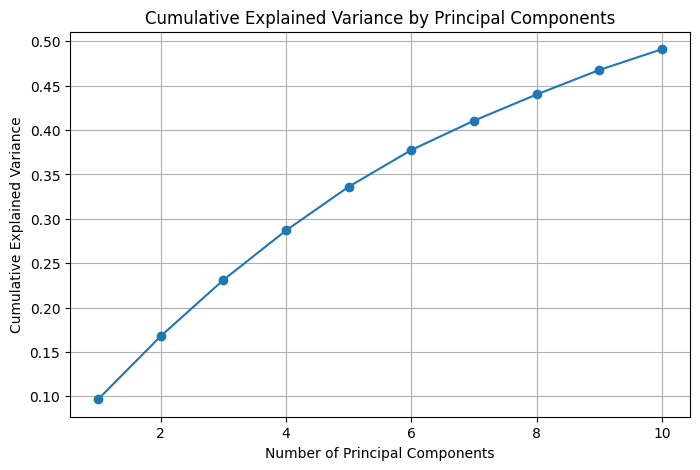

Variances:[5.07821134 3.73474107 3.32068165 2.92429288 2.58572318 2.16902598
 1.73423302 1.54885368 1.44697988 1.22955789]


In [17]:
pca = PCA(n_components=10)  # Start with full dimensionality
variances = pca.fit(X_array)

# Calculate cumulative explained variance manually
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Principal Components")
plt.grid()
plt.show()

print(f"Variances:{variances}")


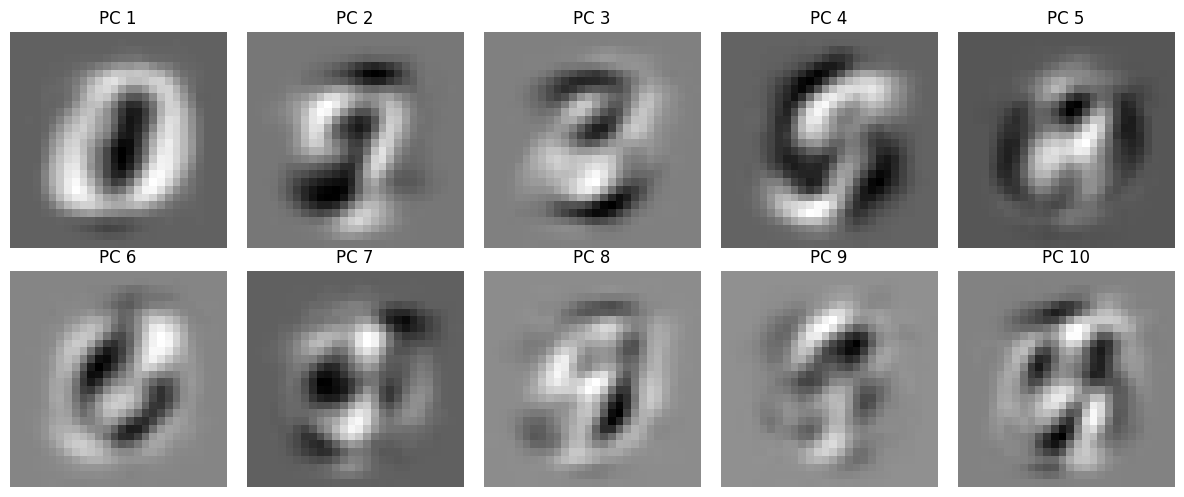

In [12]:
# Visualize first 10 principal components
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()
for i in range(10):
    pc_image = pca.components[:, i].reshape(28, 28)
    axes[i].imshow(pc_image, cmap='gray')
    axes[i].set_title(f"PC {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()


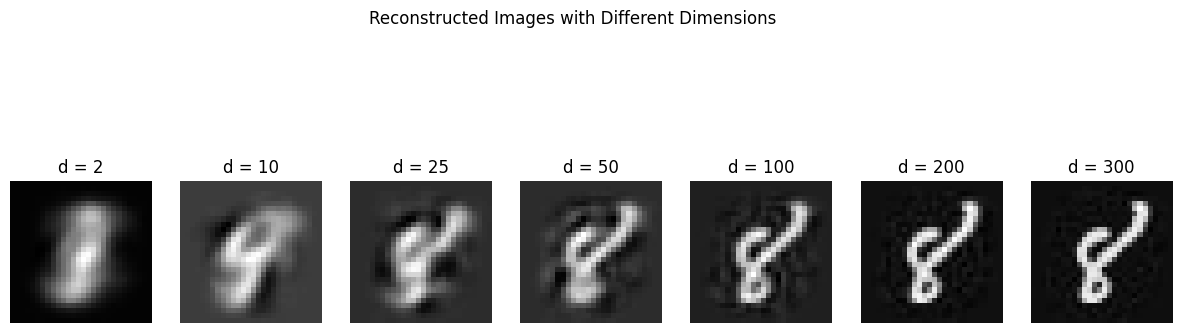

In [13]:
# Reconstruct the dataset with different dimensions
dimensions = [2, 10, 25, 50, 100, 200, 300]
fig, axes = plt.subplots(1, len(dimensions), figsize=(15, 5))

for i, d in enumerate(dimensions):
    pca = PCA(n_components=d)
    pca.fit(X_array)
    transformed_data = pca.transform(X_array)
    reconstructed_data = pca.inverse_transform(transformed_data)
    
    axes[i].imshow(reconstructed_data[800].reshape(28, 28), cmap='gray')
    axes[i].set_title(f"d = {d}")
    axes[i].axis('off')

plt.suptitle("Reconstructed Images with Different Dimensions")
plt.show()


# TASK 2

In [14]:
import numpy as np
import matplotlib.pyplot as plt

class KMeans:
    def __init__(self, k=2, max_iters=100, tol=1e-4, random_state=42):
        """
        Initializes the KMeans clustering model.
        
        Parameters:
        k (int): Number of clusters.
        max_iters (int): Maximum number of iterations.
        tol (float): Tolerance for convergence.
        random_state (int): Seed for random number generator for reproducibility.
        """
        self.k = k
        self.max_iters = max_iters
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.wcss_ = []
    
    def initialize_centroids(self, data):
        """Randomly initialize centroids by selecting k points from the data."""
        np.random.seed(self.random_state)
        random_indices = np.random.choice(data.shape[0], self.k, replace=False)
        self.centroids = data[random_indices]
        self.initial_centroids = self.centroids.copy()  # Store the initial centroids

    
    def compute_distances(self, data):
        """Compute the Euclidean distance from each point to each centroid."""
        distances = np.zeros((data.shape[0], self.k))
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.linalg.norm(data - centroid, axis=1)
        return distances
    
    def assign_clusters(self, distances):
        """Assign each point to the nearest centroid based on computed distances."""
        return np.argmin(distances, axis=1)
    
    def update_centroids(self, data, labels):
        """Update centroids by calculating the mean of points in each cluster."""
        new_centroids = np.zeros((self.k, data.shape[1]))
        for i in range(self.k):
            cluster_points = data[labels == i]
            new_centroids[i] = cluster_points.mean(axis=0) if len(cluster_points) > 0 else self.centroids[i]
        self.centroids = new_centroids
    
    def calculate_wcss(self, data, labels):
        """Calculate within-cluster sum of squares (WCSS)."""
        wcss = 0
        for i, centroid in enumerate(self.centroids):
            cluster_points = data[labels == i]
            wcss += np.sum((cluster_points - centroid) ** 2)
        return wcss
    
    def fit(self, data):
        """
        Run the K-means algorithm on the data.
        
        Parameters:
        data (numpy array): The dataset to cluster.
        """
        self.initialize_centroids(data)
        
        for iteration in range(self.max_iters):
            distances = self.compute_distances(data)
            labels = self.assign_clusters(distances)
            self.update_centroids(data, labels)
            
            # Calculate and store WCSS
            wcss = self.calculate_wcss(data, labels)
            self.wcss_.append(wcss)
            
            # Check for convergence
            if iteration > 0 and abs(self.wcss_[-2] - self.wcss_[-1]) < self.tol:
                break
            
            self.labels_ = labels  # Store labels for final clusters
    
    def predict(self, data):
        """
        Predict the nearest cluster for each data point.
        
        Parameters:
        data (numpy array): New data points to assign to clusters.
        
        Returns:
        numpy array: Cluster labels for each data point.
        """
        distances = self.compute_distances(data)
        return self.assign_clusters(distances)
    
    def plot_wcss(self):
        """Plot the WCSS (error function) over iterations."""
        plt.plot(range(1, len(self.wcss_) + 1), self.wcss_, marker='o')
        plt.xlabel("Iterations")
        plt.ylabel("WCSS (Within-cluster Sum of Squares)")
        plt.title("Error Function (WCSS) vs Iterations")
        plt.show()
    
    def plot_clusters(self, data):
        """Plot the clustered data with initial and final centroids."""
        if self.labels_ is None:
            raise ValueError("Model has not been fitted yet.")

        # Plot data points colored by their cluster labels
        plt.scatter(data[:, 0], data[:, 1], c=self.labels_, cmap='viridis', alpha=0.5, label='Data Points')
        
        # Plot initial centroids
        plt.scatter(self.initial_centroids[:, 0],self.initial_centroids[:, 1],c='blue',marker='o',s=150,edgecolor='k',label='Initial Centroids')
        
        # Plot final centroids
        plt.scatter(self.centroids[:, 0],self.centroids[:, 1],c='red',marker='x',s=150,label='Final Centroids')
        
        plt.title(f"K-Means Clustering with k={self.k}")
        plt.legend()
        plt.show()


    def plot_voronoi_regions(self, data):
        # Plot data points
        plt.scatter(data[:, 0], data[:, 1], c=self.labels_, cmap='viridis', alpha=0.5)

        # Get plot range based on data
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        # Plot each centroid and bisector between centroid pairs
        for i, centroid in enumerate(self.centroids):
            plt.scatter(centroid[0], centroid[1], c='red', marker='x', s=100)
        
        # Draw bisectors between each pair of centroids
        for i in range(self.k):
            for j in range(i + 1, self.k):
                # Midpoint between two centroids
                midpoint = (self.centroids[i] + self.centroids[j]) / 2
                
                # Slope of the line connecting the two centroids
                delta_y = self.centroids[j][1] - self.centroids[i][1]
                delta_x = self.centroids[j][0] - self.centroids[i][0]
                
                if delta_x == 0:  # Vertical line
                    plt.axvline(x=midpoint[0], color='orange', linestyle='--')
                else:
                    # Perpendicular bisector slope
                    slope = -delta_x / delta_y
                    
                    # y = mx + c form of the bisector
                    intercept = midpoint[1] - slope * midpoint[0]
                    
                    # Generate line points for plotting within the plot range
                    x_vals = np.linspace(x_min, x_max, 500)
                    y_vals = slope * x_vals + intercept
                    
                    # Plot the line (Voronoi boundary)
                    plt.plot(x_vals, y_vals, 'orange', linestyle='--')
        
        plt.title(f"Voronoi Regions for K = {self.k}")
        plt.show()


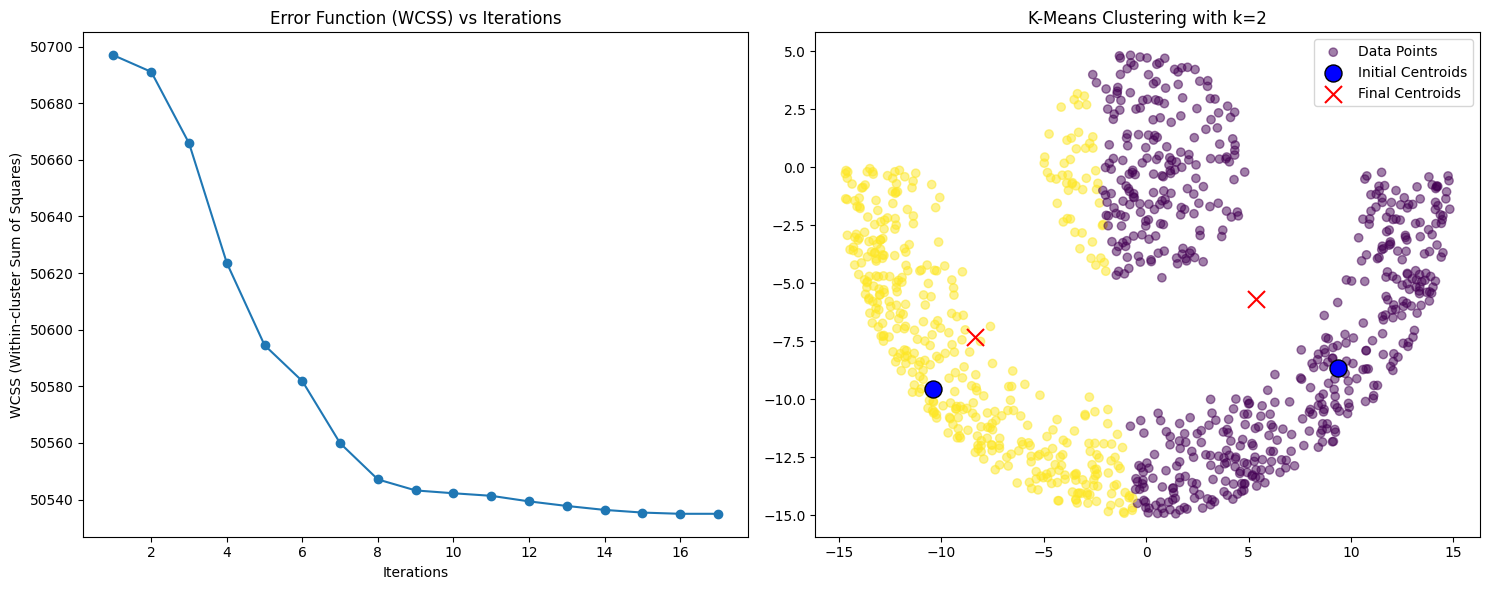

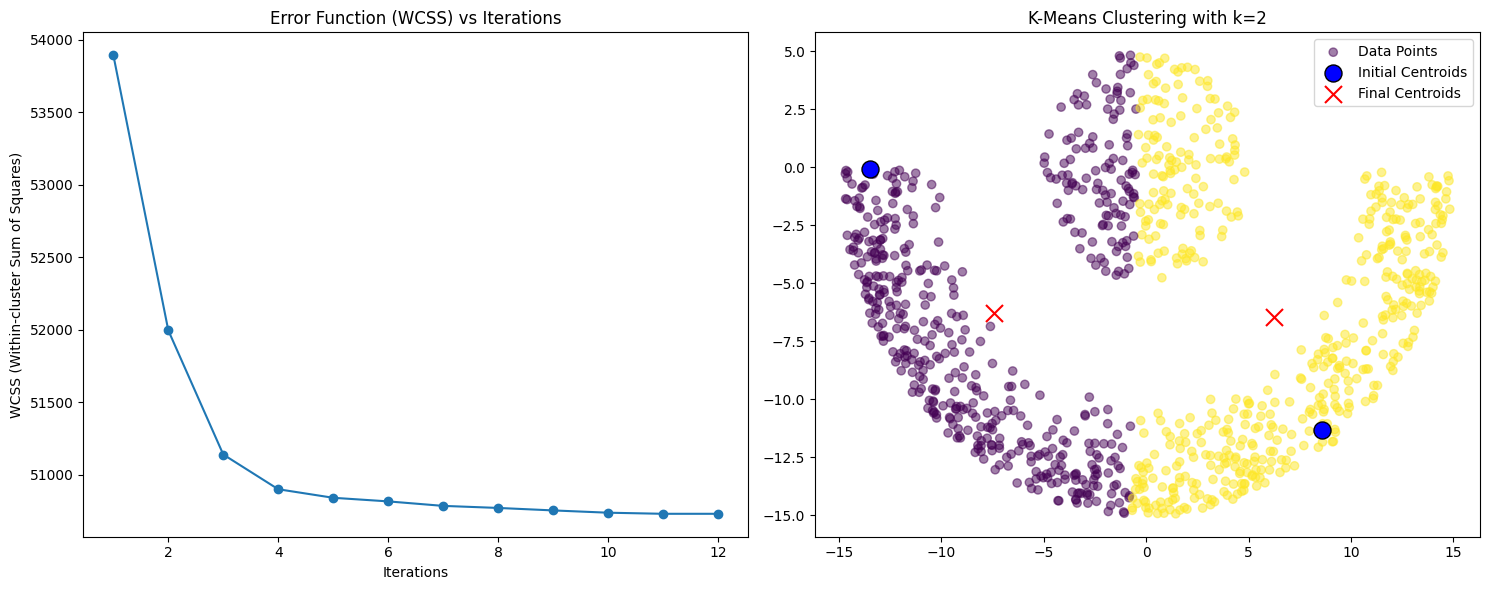

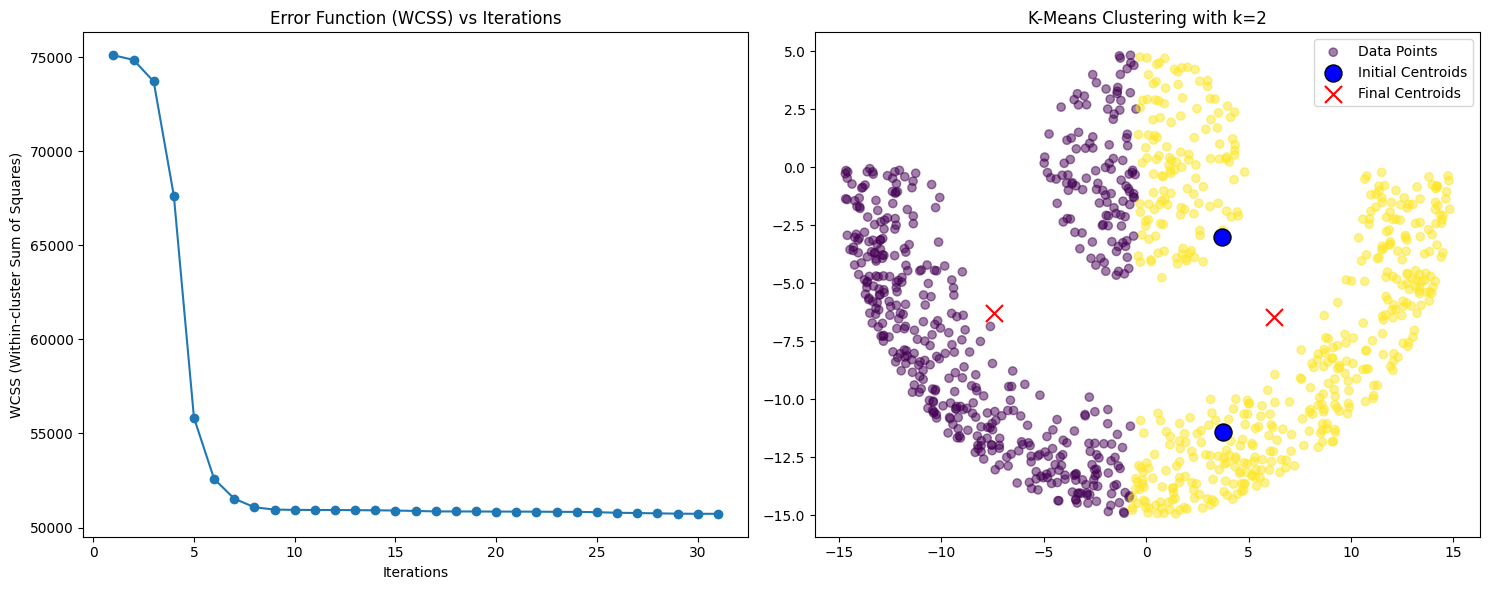

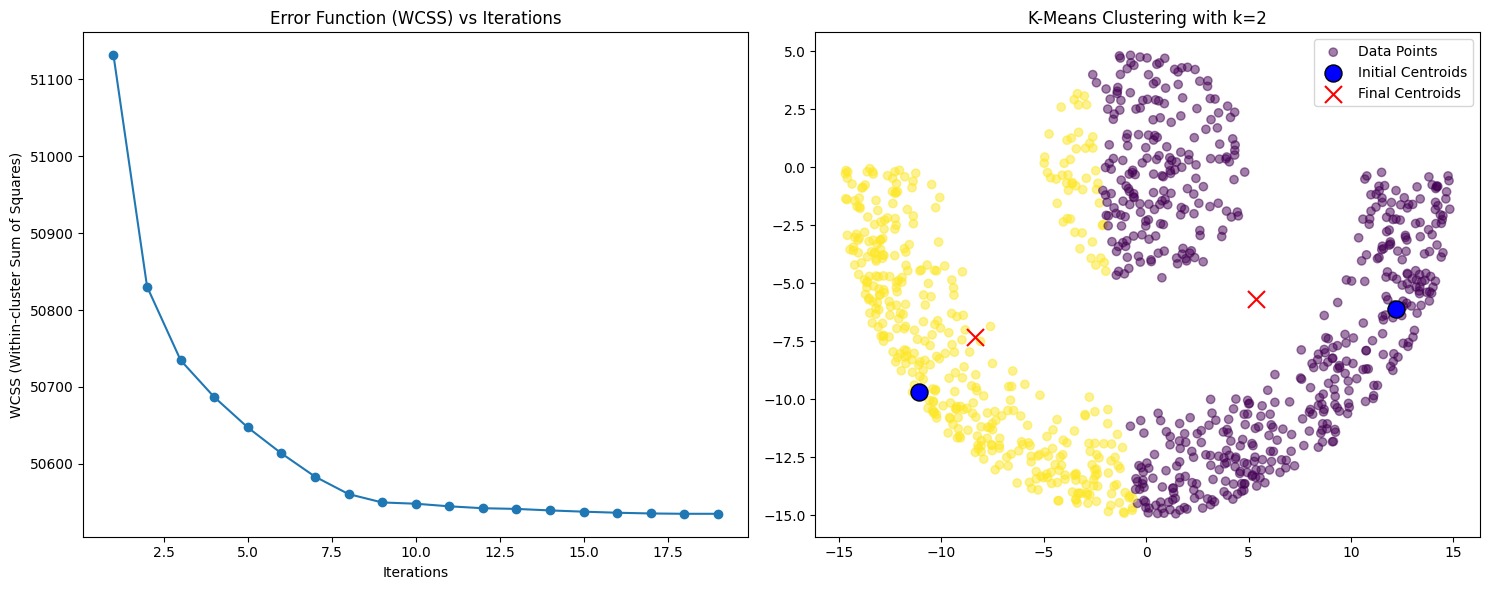

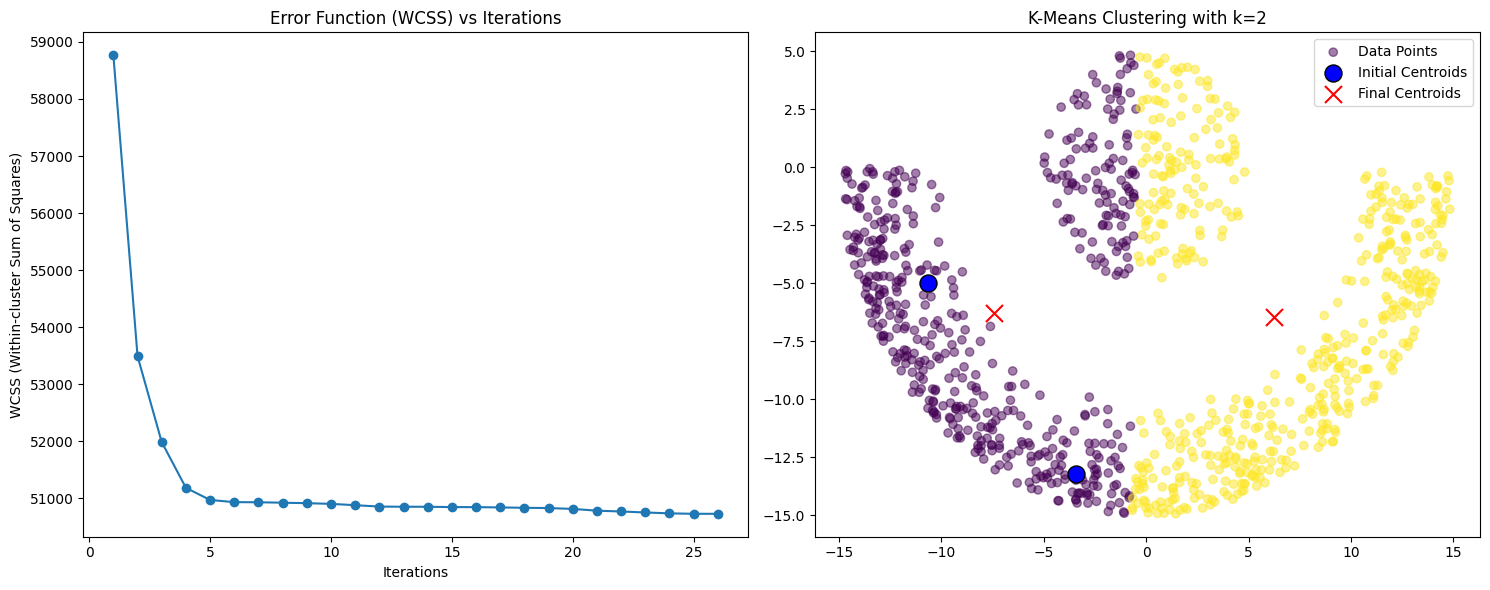

In [15]:
data = pd.read_csv("cm_dataset_2.csv", header=None).values
for i in range(5):
    # Create an instance of KMeans with k=2
    kmeans = KMeans(k=2, random_state=i)

    # Fit the model to the data
    kmeans.fit(data)

    # Create subplots for WCSS and clusters
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the WCSS on the first subplot
    axes[0].plot(range(1, len(kmeans.wcss_) + 1), kmeans.wcss_, marker='o')
    axes[0].set_xlabel("Iterations")
    axes[0].set_ylabel("WCSS (Within-cluster Sum of Squares)")
    axes[0].set_title("Error Function (WCSS) vs Iterations")

    # Plot the clusters on the second subplot
    scatter = axes[1].scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5, label='Data Points')
    axes[1].scatter(kmeans.initial_centroids[:, 0], kmeans.initial_centroids[:, 1], c='blue', marker='o', s=150, edgecolor='k', label='Initial Centroids')
    axes[1].scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=150, label='Final Centroids')
    axes[1].set_title(f"K-Means Clustering with k={kmeans.k}")
    axes[1].legend()

    # Adjust spacing
    plt.tight_layout()
    plt.show()


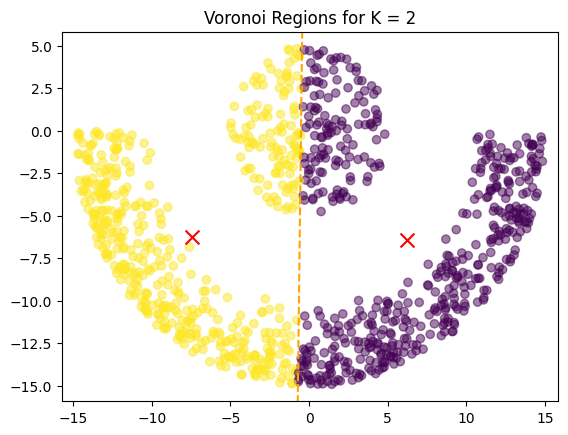

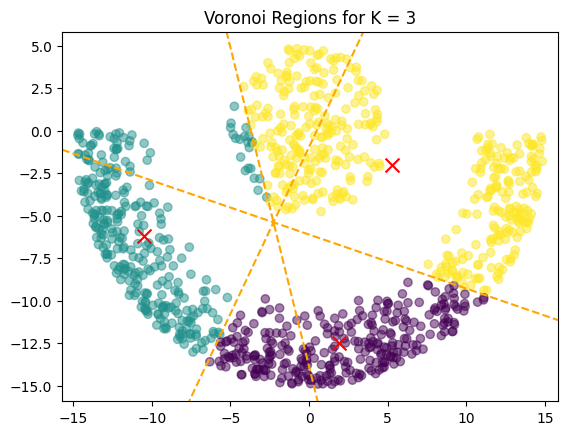

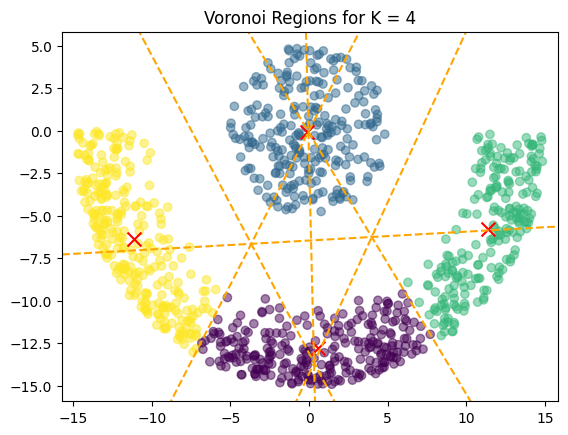

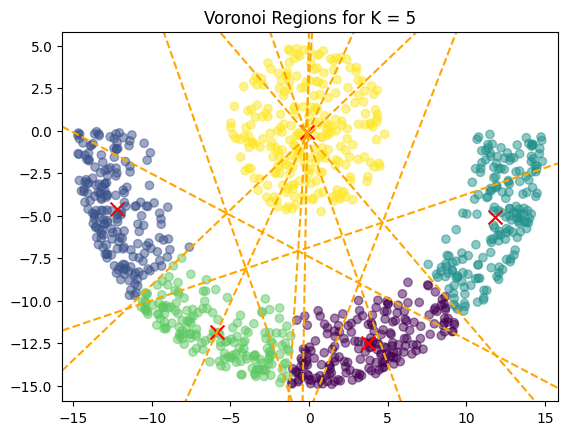

In [16]:
for k in [2, 3, 4, 5]:
    # Create an instance of KMeans with fixed initialization for each k
    kmeans = KMeans(k=k)
    
    # Fit the model to the data
    kmeans.fit(data)
    
    # Plot the Voronoi regions
    kmeans.plot_voronoi_regions(data)